## Limits of Autoregulation - Summary Statistics

In this notebook we look at the characteristics of the physiologic data when patients move from inside to outside the limits of autoregulation.

#### Useful Imports and Preliminaries

In [1]:
import os
import sys
sys.path.append("..")  # add project root
import random

import h5py

import numpy as np
import zarr
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from tqdm import tqdm

from src.data_utils import *
from src.constants import *

# pending useful sklearn imports
from scipy.stats import pearsonr
import dask.array as da

In [2]:
pd.options.display.float_format = '{:10,.2f}'.format

In [3]:
plt.rcParams.update({
    'xtick.bottom': True,
    'ytick.left': True
})

In [4]:
np.random.seed(420)
random.seed(420)

In [5]:
sns.set_theme(context="talk")

In [6]:
# path constants
data_dir = "/home/mr2238/project_pi_np442/mr2238/accelerate/data"
img_dir = "/home/mr2238/project_pi_np442/mr2238/accelerate/imgs/in_out"
global_path = "/home/mr2238/project_pi_np442/mr2238/accelerate/data/processed/all_data.hdf5"
labels_path = os.path.join(data_dir, "labels")
raw_data_path = os.path.join(data_dir, "raw_data")

In [7]:
# check img directory exists, if not make it
os.makedirs(img_dir, exist_ok=True)

In [8]:
# list files
h5py_files = [f for f in os.listdir(raw_data_path) if f.endswith(".icmh5")]
print(f"Number of h5py files: {len(h5py_files)}")
print(f"Example file: {h5py_files[0]}")

Number of h5py files: 215
Example file: 1002.icmh5


In [9]:
# from dask.distributed import LocalCluster
# cluster = LocalCluster()          # Fully-featured local Dask cluster
# client = cluster.get_client()

In [10]:
# client

### In and Out Statistics

#### Define Limits

Here we explore how much a given patient is within their autoregulatory limits, to get a sense of how to distribute this.
1) Definition: Patient is outside limits of autoregulation if at a given time *t*, the mean ABP value over the minute prior to time *t* is outside the limits calculated at *t*.
2) What do we want?
    - Distribution of % time outside limits: Done
    - Duration of time outside limits: per patient, distribution, median, average
    - Number of times outside limits per patient
    - Correlation between time elapsed and likelihood of being outside of limits: t vs. at time t, what fraction of patients are outside limits?
    - time spent outside autoregulation vs time to autoregulation calc

#### Percent Time In and Out

In [11]:
true_false = {}
ins = []
mode = 'mean'
with h5py.File(global_path, "r") as f:
    for pt in f['healthy_ptids'][...].astype(str):
        in_out_df = pd.Series(f[f"{pt}/processed/in_out_{mode}/in_out"][...]).astype(bool)
        idx_window = pd.DataFrame(f[f"{pt}/processed/in_out_{mode}/window_idx"][...])

        # to actually get percentage of time spent outside autoregulation, we need to get actual window length, we can't weigh all the windows equally
        len_window = idx_window.iloc[:, 1] - idx_window.iloc[:, 0]
        in_out = (in_out_df * len_window).sum() / len_window.sum()
        if len_window.sum() == 0:
            print(pt)
            print(idx_window)
            print(in_out_df)
            # continue

        true_false[pt] = [in_out]
        ins.append(in_out_df)


In [12]:
true_false_df = pd.DataFrame(true_false).transpose()
bool_in_out_df = pd.concat(ins)
bool_in_out_df.describe()
true_false_df = true_false_df.rename(columns={true_false_df.columns[0]: 'in_percent'})

In [13]:
# calculate percent time in/out per patient, need to switch because in_out is True if in
percent_time = 1- np.array(true_false_df).squeeze()
print(percent_time.shape)

(185,)


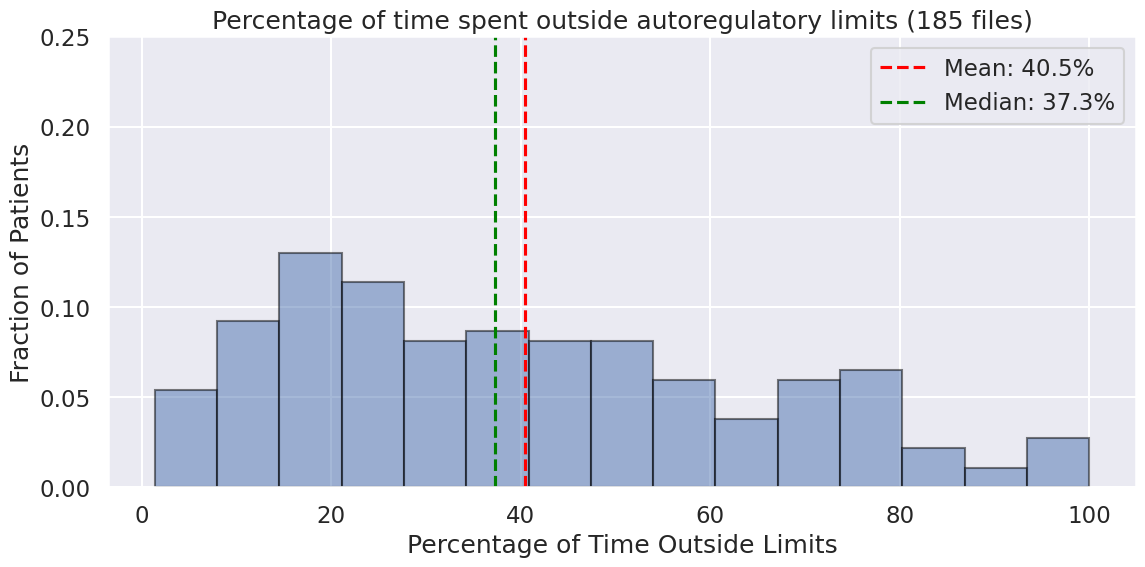

In [14]:
# plot distribtion
fig, ax = plt.subplots(figsize=(12,6))
fig.tight_layout(pad=2)
sns.histplot(percent_time * 100, ax=ax, stat="probability", edgecolor=(0, 0, 0, 0.5), alpha=0.5, bins=15)
# sns.kdeplot(
#     percent_time / percent_time.sum(),
#     ax=ax,
#     bw_adjust=1,
#     linewidth=2,
#     cut=0,
# )
ax.set_title(f"Percentage of time spent outside autoregulatory limits ({len(percent_time)} files)")
ax.set_xlabel('Percentage of Time Outside Limits')
ax.set_ylabel("Fraction of Patients")
ax.set_ylim(0, 0.25)
ax.set_xticks(np.arange(0, 1, 0.1), minor=True)

mean_value = pd.Series(percent_time).mean()
ax.axvline(x=mean_value * 100, color='red', linestyle='--', label=f'Mean: {mean_value * 100:.1f}%')
ax.legend()

med_value = pd.Series(percent_time).median()
ax.axvline(x=med_value * 100, color='green', linestyle='--', label=f'Median: {med_value * 100:.1f}%')
ax.legend()

img_name = f"in_out_percent_distribution.png"
plt.savefig(os.path.join(img_dir, img_name), bbox_inches='tight')
plt.show()

Now, we can correlate this with the time required to calculate MAP opt.

In [15]:
# load df, find seconds elapsed to calculate opt MAP
with h5py.File(global_path, "r") as f:
    rows = []
    calc = TARGETS
    for pt in f['healthy_ptids'][...].astype(str):
        time_to_mapopt = find_time_elapsed(str(pt), calc, labels_path, time="s", start_time=int(f[f"{pt}/raw/"].attrs["dataStartTimeUnix"][0]))
        rows.append([time_to_mapopt, str(pt)])
    elapsed_times = pd.DataFrame(rows, columns=['time', 'ptid'])
    elapsed_times_idx = elapsed_times.set_index('ptid').dropna()
    elapsed_times_idx = elapsed_times_idx[elapsed_times_idx > 0]

neg time 597_3, returning 0.
neg time 690_3, returning 0.


In [16]:
# merge dfs
timevpercent = pd.merge(1 - true_false_df, elapsed_times_idx, left_index=True, right_index=True, how='inner')
timevpercent = timevpercent.rename(columns={'in_percent' : 'out_percent'})
timevpercent = timevpercent[timevpercent['time'] > 0]
timevpercent


,out_percent,time
1198,1.00,"5,229.00"
239,0.11,"12,560.00"
318,0.26,"4,219.00"
596,0.11,"16,628.00"
1120,1.00,"11,650.00"
...,...,...
769,0.08,"7,813.00"
1077,0.05,"10,516.00"
233,0.36,"11,117.00"
1659,0.80,"21,973.00"


In [17]:
x, y = timevpercent["out_percent"], np.log(timevpercent["time"])
r, p = pearsonr(x, y)

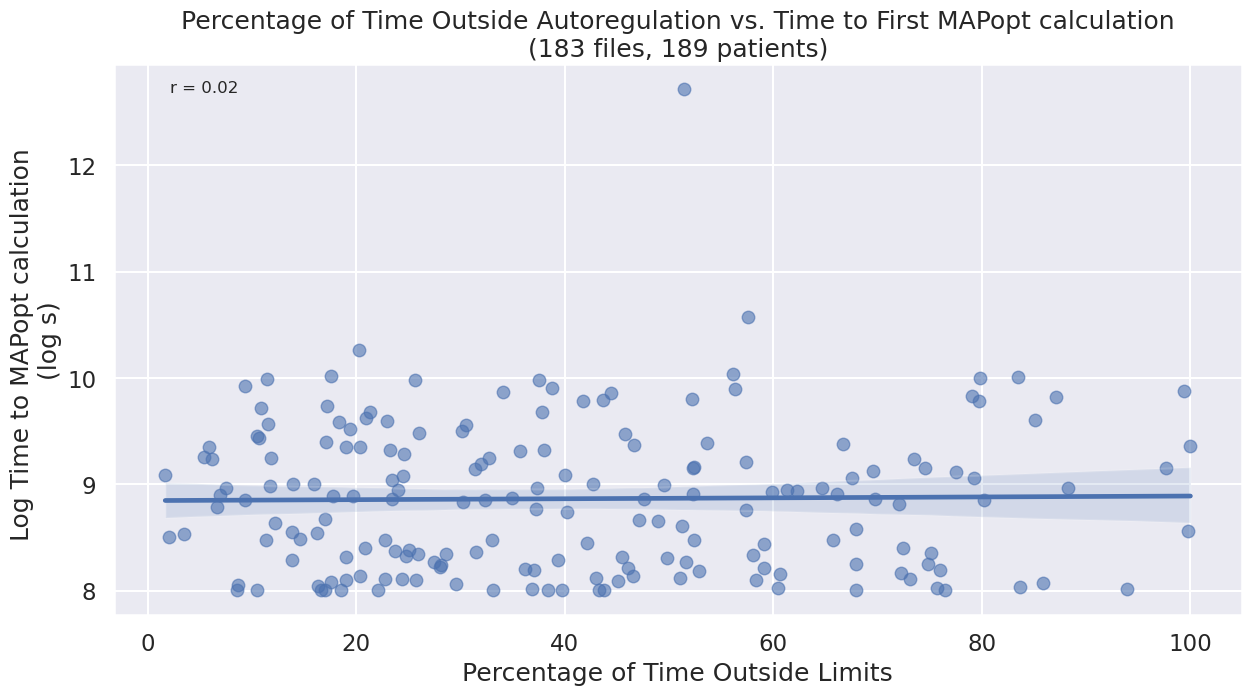

In [18]:
# plot correlation
fig, ax = plt.subplots(figsize=(12,6))
fig.tight_layout(pad=0)
sns.regplot(x = x*100, y = np.log(timevpercent["time"]), scatter_kws={'alpha':0.6})
ax.set_title(f"Percentage of Time Outside Autoregulation vs. Time to First MAPopt calculation\n({timevpercent.shape[0]} files, 189 patients)")
ax.set_xlabel('Percentage of Time Outside Limits')
ax.set_ylabel("Log Time to MAPopt calculation \n(log s)")
# ax.set_ylim(7.5, 11)
# ax.set_xticks(np.arange(0, 1, 0.1), minor=True)

# mean_value = pd.Series(percent_time).mean()
# ax.axvline(x=mean_value * 100, color='red', linestyle='--', label=f'Mean: {mean_value * 100:.0f}%')
# ax.legend()

# med_value = pd.Series(percent_time).median()
# ax.axvline(x=med_value * 100, color='green', linestyle='--', label=f'Median: {med_value * 100:.0f}%')
# ax.legend()
plt.text(0.05, 0.95, f"r = {r:.2f}", transform=plt.gca().transAxes, fontsize=12)

# img_name = f"in_out_percent_distribution.png"
# plt.savefig(os.path.join(img_dir, img_name), bbox_inches='tight')
plt.show()

Notice there is no correlation. Most likely due to the fact that time to MAPopt calc depends on a time period for which there are no autoregulatory limits.

We can also see how the likelihood of being outside the limits is correlated with time elapsed from start of recording.

In [19]:
# get in_out for each patient, add n/a if time index is not represented
# concat and plot
frames = []
with h5py.File(global_path, "r") as f:
    for pt in tqdm(f['healthy_ptids'][...].astype(str)):
        processed_data_path = f"{pt}/processed/in_out_{mode}/"
        label_datetimes = pd.to_datetime(f[processed_data_path + "label_timestamp"][...], unit="us", origin="unix")
        zero_idx = label_datetimes - pd.to_datetime((f[f"{pt}/raw"].attrs["dataStartTimeUnix"]).astype(np.int64) * 1e6, unit="us", origin="unix")[0]
        in_out_df = f[f"{pt}/processed/in_out_{mode}/in_out"][...]

        df = pd.DataFrame({
            "timestamp": zero_idx,
            f"in_out_{pt}": 1 - in_out_df
        })
        frames.append(df)

continuous_time_grid = pd.concat(frames, axis=0)
print(continuous_time_grid.shape)
grid_groups = continuous_time_grid.groupby("timestamp", as_index=False)
count_per_timestamp = grid_groups.first()
        

100%|██████████| 185/185 [00:01<00:00, 123.89it/s]


(227563, 186)


/tmp/ipykernel_1848629/1064456729.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  count_per_timestamp = grid_groups.first()


In [20]:
count_per_timestamp['timestamp']

0        0 days 00:01:26
1        0 days 00:02:26
2        0 days 00:03:26
3        0 days 00:04:26
4        0 days 00:05:26
              ...       
72805   13 days 10:12:18
72806   13 days 10:13:18
72807   13 days 10:14:18
72808   13 days 10:15:18
72809   13 days 10:16:18
Name: timestamp, Length: 72810, dtype: timedelta64[ns]

In [21]:
# will do min because that looks better
agg_counts = pd.DataFrame(count_per_timestamp['timestamp'])
agg_counts['sum'] = count_per_timestamp.drop('timestamp', axis = 1).sum(axis=1)
hourly_df = agg_counts.resample('min', on='timestamp').sum()

In [22]:
hourly_df

,sum
timestamp,
0 days 00:01:26,1.00
0 days 00:02:26,1.00
0 days 00:03:26,1.00
0 days 00:04:26,1.00
0 days 00:05:26,1.00
...,...
13 days 10:11:26,1.00
13 days 10:12:26,1.00
13 days 10:13:26,1.00


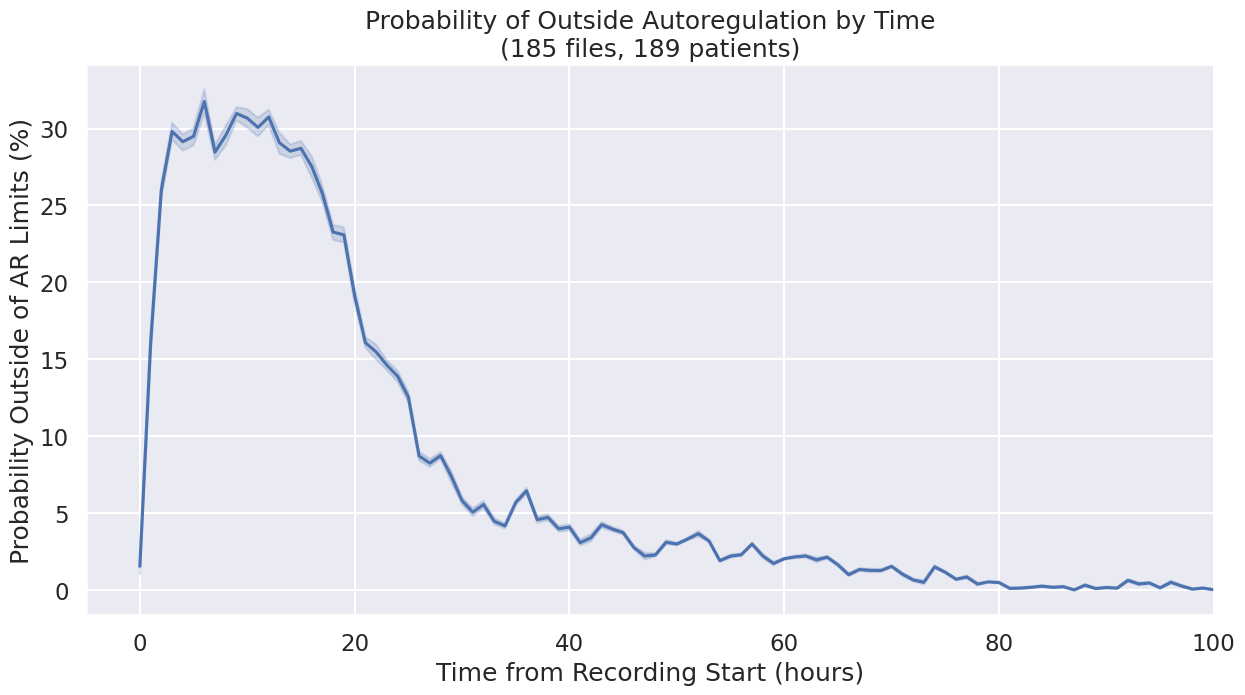

In [23]:
# plot 
fig, ax = plt.subplots(figsize=(12,6))
fig.tight_layout(pad=0)
sns.lineplot(x = hourly_df.index/(1e9*60*60), y = hourly_df['sum']/(count_per_timestamp.shape[1] - 1) * 100)
ax.set_title(f"Probability of Outside Autoregulation by Time\n({count_per_timestamp.shape[1] - 1} files, 189 patients)")
ax.set_xlabel('Time from Recording Start (hours)')
ax.set_ylabel("Probability Outside of AR Limits (%)")

ax.set_xlim(-5, 100)
ax.set_xticks(np.arange(0, 100, 5), minor=True)

img_name = f"in_out_prob_by_time.png"
plt.savefig(os.path.join(img_dir, img_name), bbox_inches='tight')
plt.show()

#### Amount of time spent outside of limits

We can do this in one minute intervals, basically develop a function that makes a list of segments of interrupted outside status with their lengths.

In [24]:
minutes_out_per_pt = count_per_timestamp.iloc[:, 1:].sum(axis=0)

In [25]:
minutes_out_per_pt.describe()

count       185.00
mean        486.28
std         471.51
min           1.00
25%         200.00
50%         359.00
75%         629.00
max       2,865.00
dtype: float64

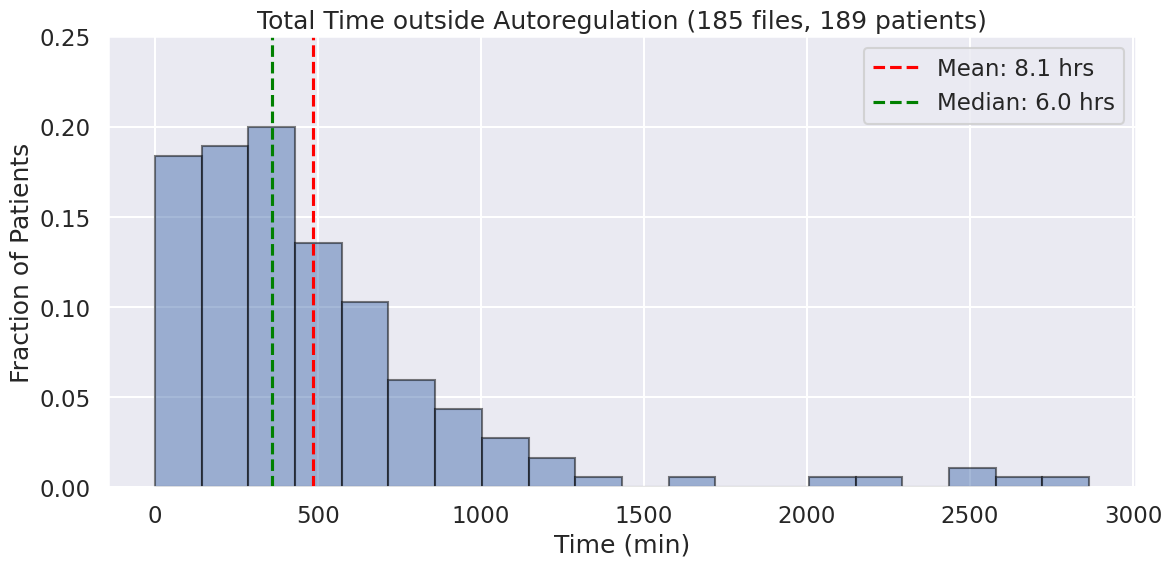

In [26]:
# plot distribution of minutes out
fig, ax = plt.subplots(figsize=(12,6))
fig.tight_layout(pad=2)
sns.histplot(minutes_out_per_pt, ax=ax, stat="probability", edgecolor=(0, 0, 0, 0.5), alpha=0.5,)
ax.set_title(f"Total Time outside Autoregulation ({len(percent_time)} files, 189 patients)")
ax.set_xlabel('Time (min)')
ax.set_ylabel("Fraction of Patients")
ax.set_ylim(0, 0.25)
ax.set_xticks(np.arange(0, 1, 0.1), minor=True)

mean_value = minutes_out_per_pt.mean()
ax.axvline(x=mean_value, color='red', linestyle='--', label=f'Mean: {mean_value/60:.1f} hrs')
ax.legend()

med_value = minutes_out_per_pt.median()
ax.axvline(x=med_value, color='green', linestyle='--', label=f'Median: {med_value/60:.1f} hrs')
ax.legend()

img_name = f"in_out_percent_distribution.png"
# plt.savefig(os.path.join(img_dir, img_name), bbox_inches='tight')
plt.show()

In [27]:
minutes_out_per_pt

in_out_1198       518.00
in_out_239         89.00
in_out_318        381.00
in_out_596         58.00
in_out_1120       200.00
                 ...    
in_out_769         92.00
in_out_1077        22.00
in_out_233        357.00
in_out_1659       565.00
in_out_1532       635.00
Length: 185, dtype: float64

In [28]:
# correlate that with time to MAPopt calculation (the longer it takes to calculate, the longer they REMAIN outside limits???)
# there is a wild outlier where it takes more than 60_000 min to compute time so we will remove
# merge time out and minutes_out_per_patient
tmp = minutes_out_per_pt.reset_index()
tmp['index'] = tmp['index'].str.removeprefix('in_out_')
tmp = tmp.set_index('index', drop=True)
tmp = tmp.rename(columns={tmp.columns[0] : "time_out"})
reg_data = pd.merge(tmp, elapsed_times_idx, left_index=True, right_index=True, how='inner').rename(columns={"time" : "time_to_calc"})
filtered = reg_data[reg_data['time_to_calc'] < 60_000]

In [29]:
x, y = filtered["time_to_calc"], filtered["time_out"]
r, p = pearsonr(x, y)

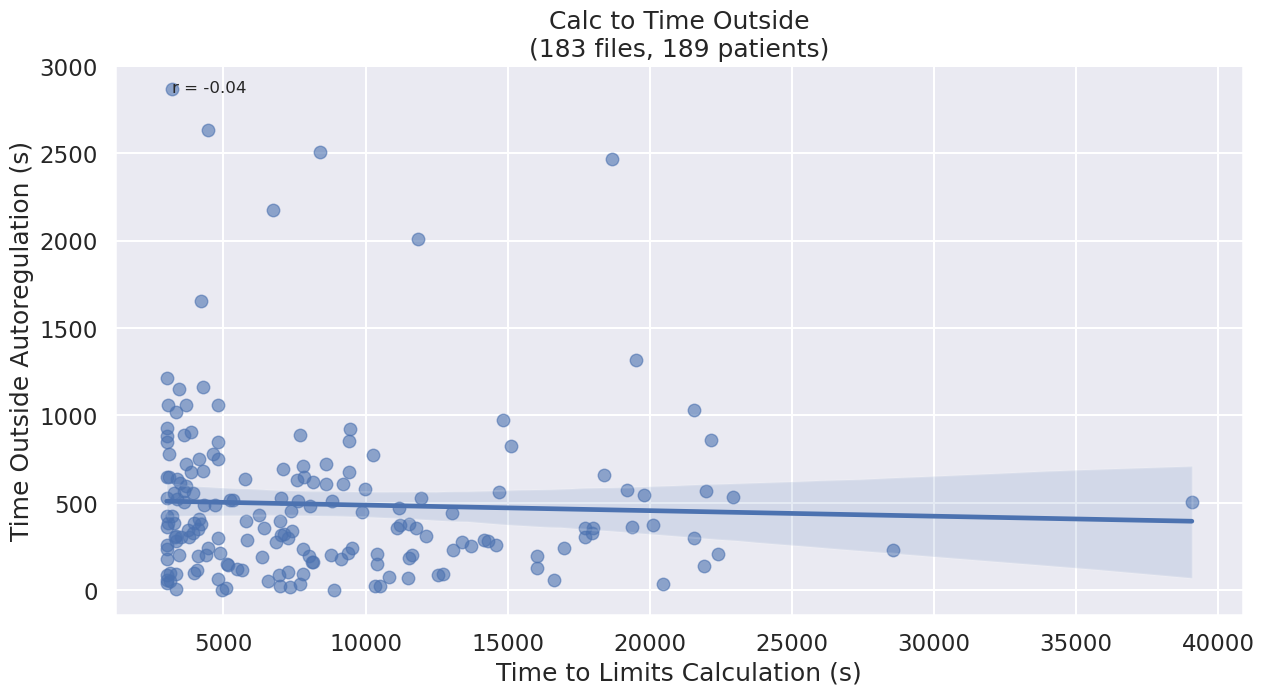

In [30]:
# plot correlation
fig, ax = plt.subplots(figsize=(12,6))
fig.tight_layout(pad=0)
sns.regplot(x = x, y =  y, scatter_kws={'alpha':0.6})
ax.set_title(f"Calc to Time Outside\n({timevpercent.shape[0]} files, 189 patients)")
ax.set_xlabel('Time to Limits Calculation (s)')
ax.set_ylabel("Time Outside Autoregulation (s)")
# ax.set_ylim(7.5, 11)
# ax.set_xticks(np.arange(0, 1, 0.1), minor=True)

# mean_value = pd.Series(percent_time).mean()
# ax.axvline(x=mean_value * 100, color='red', linestyle='--', label=f'Mean: {mean_value * 100:.0f}%')
# ax.legend()

# med_value = pd.Series(percent_time).median()
# ax.axvline(x=med_value * 100, color='green', linestyle='--', label=f'Median: {med_value * 100:.0f}%')
# ax.legend()
plt.text(0.05, 0.95, f"r = {r:.2f}", transform=plt.gca().transAxes, fontsize=12)

# img_name = f"in_out_percent_distribution.png"
# plt.savefig(os.path.join(img_dir, img_name), bbox_inches='tight')
plt.show()

### Segmentation

#### Summary Statistics

In [31]:
def get_start_time(g, full_timestamps):
    g_ts = g.index
    t_1 = full_timestamps.get_loc(g_ts[0])
    if t_1 > 0:
        return full_timestamps[t_1 - 1]
    else:
        return full_timestamps[t_1] - (60 * 1e6)

In [32]:
# now consider continuous segments, plot their average duration, median duration per patient
# correlate that with time to MAPopt calculation (the longer it takes to calculate, the more difficult they are to get out of disruption???)

# loop through each patient's in and out and get the segments
out_time = {}
mode = 'mean'
with h5py.File(global_path, "r") as f:
    for pt in f['healthy_ptids'][...].astype(str):
        out_df = ~(pd.Series(f[f"{pt}/processed/in_out_{mode}/in_out"][...], name = "out?").astype(bool))
        timestamp = pd.Series(f[f"{pt}/processed/in_out_{mode}/label_timestamp"][...], name = "timestamp")
        combined = pd.concat([out_df, timestamp], axis=1)
        combined = combined.set_index('timestamp', drop=True)

        # consider that some of these will be N/A, print them
        # print("NAs:", combined["out?"].isna().sum())

        signal = combined['out?']
        change = signal.ne(signal.shift()).cumsum()
        true_groups = (
            combined.groupby(change)
            .filter(lambda g: g['out?'].iloc[0]) # keep only True outs
            .groupby(change)
        )
        intervals = true_groups.apply(
            lambda g: pd.Series({
                'start': pd.to_datetime(get_start_time(g, combined.index), unit='us'),
                'end': pd.to_datetime(g.index[-1], unit='us'),
                'duration': g.index[-1] - get_start_time(g, combined.index)
            })
        )

        out_time[pt] = intervals



In [33]:
combined_df = pd.DataFrame([(pt, val) for pt, vals in out_time.items() for val in vals['duration']], columns = ['ptid', 'duration'])
combined_df

,ptid,duration
0,1198,"34,320,000,000.00"
1,1198,"1,500,000,000.00"
2,239,"60,000,000.00"
3,239,"60,000,000.00"
4,239,"60,000,000.00"
...,...,...
9975,1532,"120,000,000.00"
9976,1532,"420,000,000.00"
9977,1532,"180,000,000.00"
9978,1532,"60,000,000.00"


In [34]:
combined_df.describe()

,duration
count,"9,980.00"
mean,"644,729,458.92"
std,"2,564,803,323.99"
min,"60,000,000.00"
25%,"60,000,000.00"
50%,"120,000,000.00"
75%,"360,000,000.00"
max,"75,600,000,000.00"


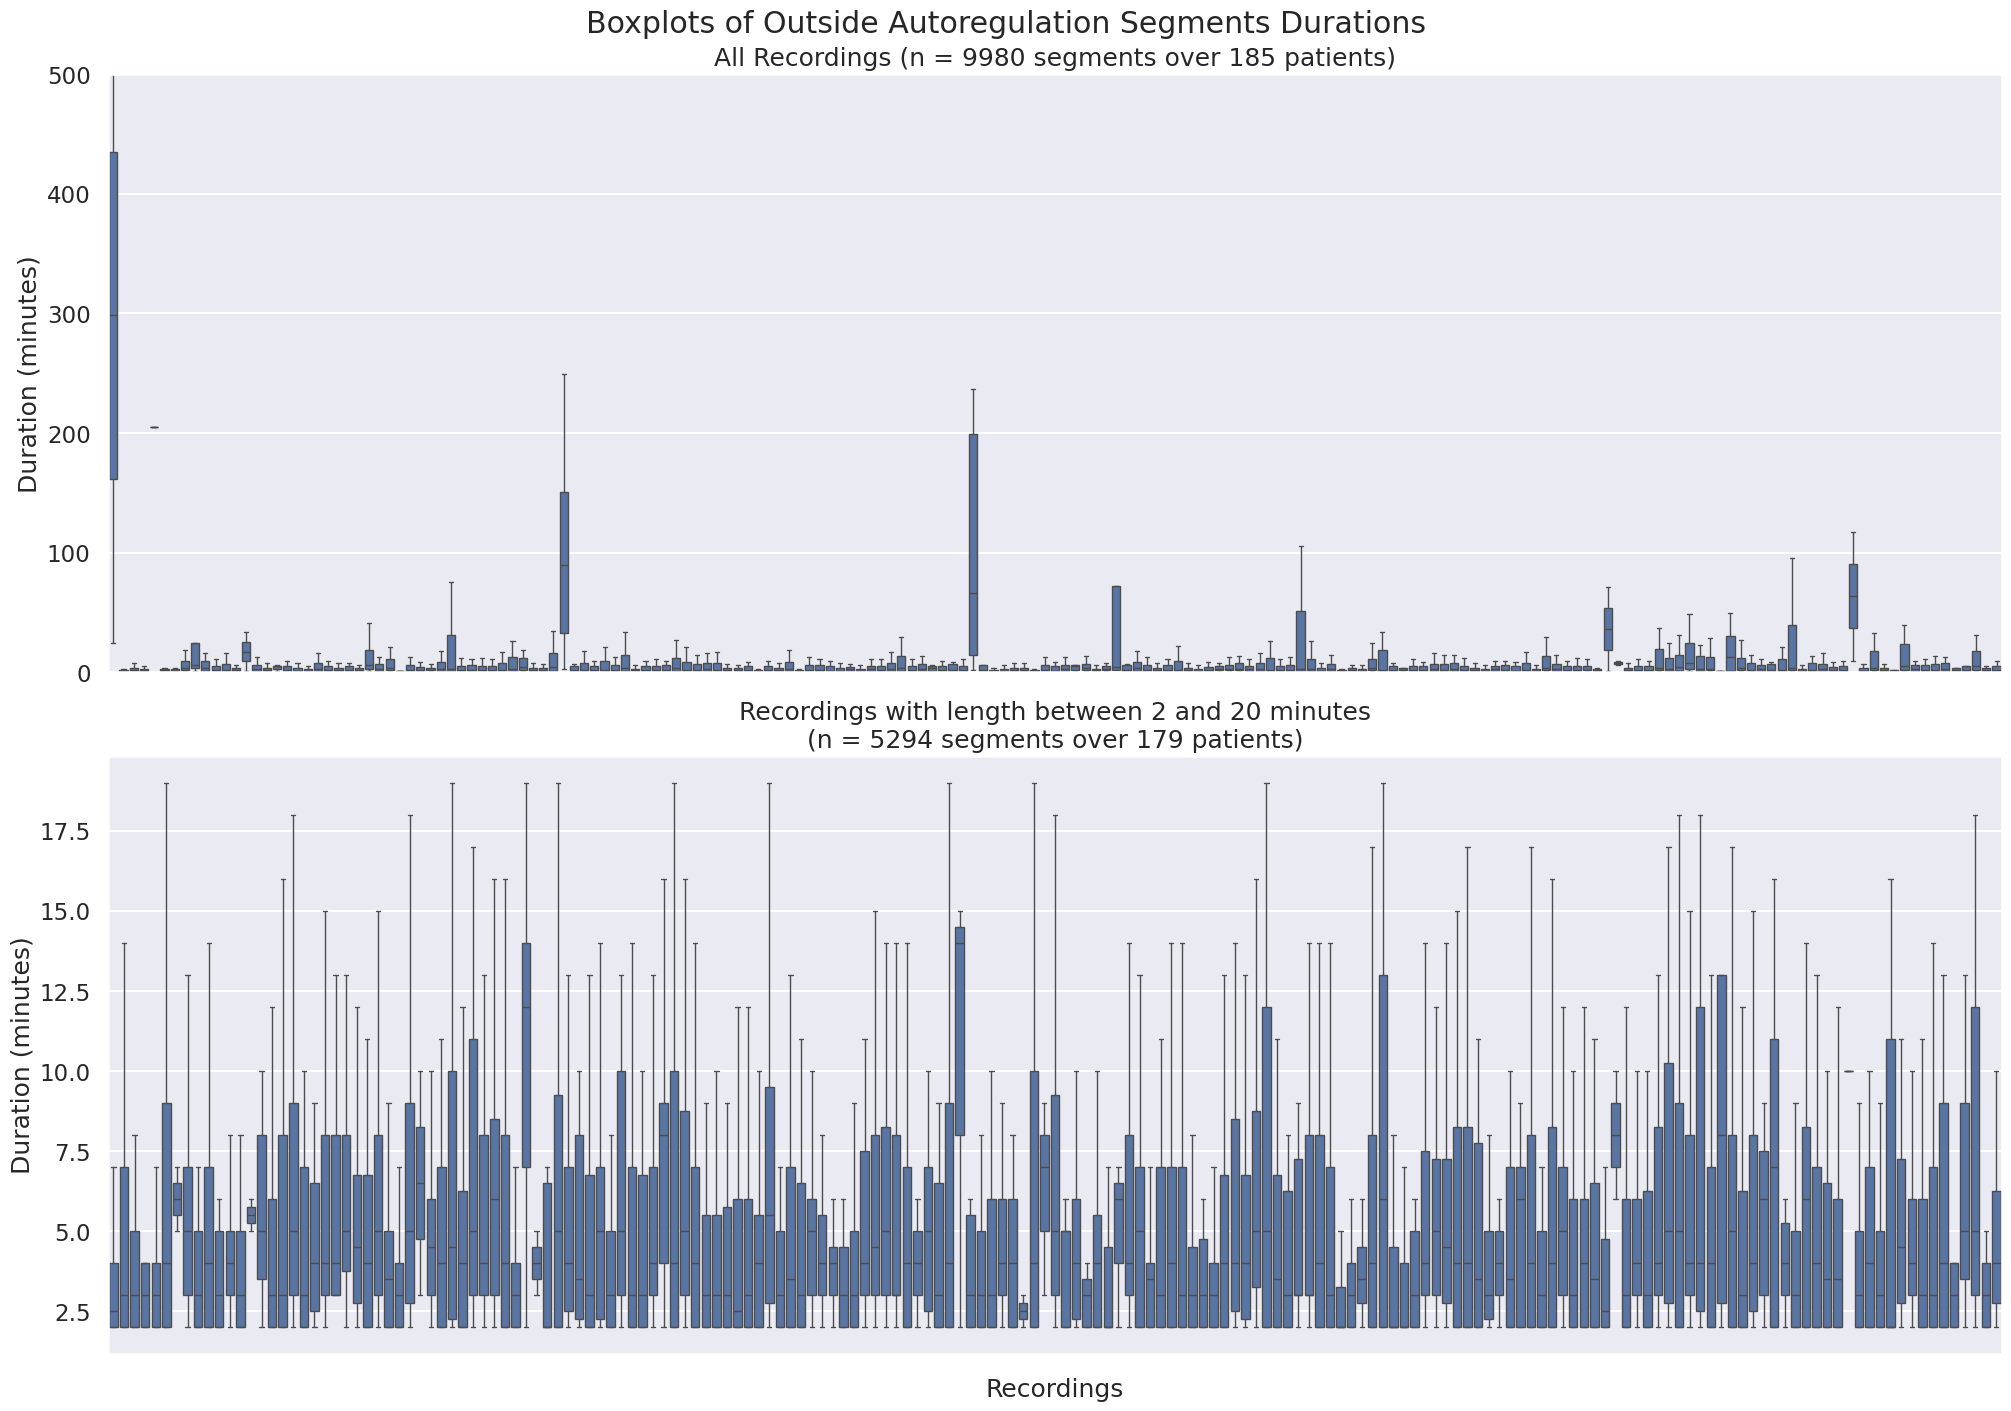

In [35]:
# violin plots
combined_df_min = combined_df.assign(duration=combined_df['duration'] / (1e6*60))
filtered = combined_df_min[(combined_df_min['duration'] < 20)*(combined_df_min['duration'] > 1)]
with plt.rc_context({'xtick.bottom': False}):
        fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(20,14), layout='constrained')
        sns.boxplot(data = combined_df_min, x='ptid', y='duration', ax=ax1, dodge=True, fliersize=0)
        sns.boxplot(data = filtered, x='ptid', y='duration', ax=ax2, dodge=True, fliersize=0)

        ax1.set_ylabel('Duration (minutes)')
        ax2.set_ylabel('Duration (minutes)')
        ax1.set_xlabel('')
        ax2.set_xlabel('Recordings')
        ax1.set_ylim(0, 500)
        ax1.xaxis.set_ticklabels([])
        ax2.xaxis.set_ticklabels([])

        fig.suptitle('Boxplots of Outside Autoregulation Segments Durations')
        ax1.set_title(f"All Recordings (n = {combined_df_min.shape[0]} segments over {combined_df_min['ptid'].unique().shape[0]} patients)")
        ax2.set_title(f"Recordings with length between 2 and 20 minutes\n(n = {filtered.shape[0]} segments over {filtered['ptid'].unique().shape[0]} patients)")

        img_name = f"out_seg_dur_per_patient.png"
        plt.savefig(os.path.join(img_dir, img_name), bbox_inches='tight')
        plt.show()

In [ ]:
# can use groupby
with h5py.File(global_path, "r") as f:
        summary_df = combined_df.groupby('ptid').apply(
            lambda x: pd.Series({
                'num_seg': x['duration'].shape[0],
                'mean': x['duration'].mean(),
                'median': x['duration'].median(),
                'stddev': x['duration'].std(),
                'max': x['duration'].max(),
                'min': x['duration'].min(),
                'freq_perhr': (x['duration'].shape[0] / float(f[f"{x.name}/raw"].attrs['duration'][0].removesuffix(' seconds'))) * 60 * 60
            }), include_groups=False
        )
summary_df

In [ ]:
# add % time in out and total length of recording to summary df and time to MAPopt calc
with h5py.File(global_path, "r") as f:
    summary_df["total_recording_s"] = summary_df.index.map(
        lambda x: (int(f[f"{x}/raw"].attrs['dataEndTimeUnix'][0]) - int(f[f"{x}/raw"].attrs['dataStartTimeUnix'][0]))
    )
summary_df["percent_out"] = timevpercent["out_percent"]
summary_df['to_first_MAPopt_s'] = elapsed_times_idx
summary_df


In [ ]:
summary_df.describe().T

In [ ]:
summary_df = summary_df[summary_df['to_first_MAPopt_s'] < 300_000]
summary_df = summary_df[summary_df['total_recording_s'] < 7_000_000]


In [ ]:
summary_df.describe().T

In [ ]:
summary_df_min = summary_df.assign(
    **summary_df[['mean', 'median', 'stddev', 'max', 'min']].transform(lambda x: x / (1e6*60))
)
summary_df_min = (
    summary_df_min.drop(columns=['to_first_MAPopt_s', 'total_recording_s'])
    .assign(
        **summary_df[['to_first_MAPopt_s', 'total_recording_s']]
          .transform(lambda x: x / 60)
          .rename(columns=lambda c: re.sub(r'_s$', '_min', c))
    )
)
summary_df_min

In [ ]:
# number of rows/cols for subplots
nrows = int(np.sqrt(len(summary_df_min.columns)))
ncols = len(summary_df_min.columns) // nrows + (len(summary_df_min.columns) % nrows) % nrows

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, layout='constrained', figsize=(8*ncols, 6*nrows))

for i, stat in enumerate(summary_df_min.columns):
    ax = axes[i//ncols, i%ncols]
    sns.violinplot(
        data=summary_df_min[stat],
        ax=ax,
        inner="box",
        cut=0,
    )
    ax.set_title(f"{stat.capitalize()}")
    ax.tick_params(axis="x", rotation=90)
    ax.set_xlabel("")
    ax.set_ylabel("")

    mean_value = summary_df_min[stat].mean()
    ax.axhline(y=mean_value, color='red', linestyle='--', label=f'Mean: {mean_value:.2f}')
    ax.legend()

# hide any unused subplots
for i, a in enumerate(axes.flat):
    if i > len(summary_df_min.columns) - 1:
        a.set_axis_off()

fig.suptitle(f"Violin plots of summary statistics of duration per window (min)")

img_name = "segments_summary_stats.png"
plt.savefig(os.path.join(img_dir, img_name))
plt.show()

In [ ]:
# then min-max scale all of these
from sklearn.preprocessing import MinMaxScaler, PowerTransformer
scaler = MinMaxScaler()
scaler_box = PowerTransformer(method='box-cox')
scaled_values = scaler.fit_transform(summary_df)
summary_df_scaled = pd.DataFrame(scaled_values, columns=summary_df.columns)
summary_df_scaled.describe().T
# then do correlation plot for all of these

In [ ]:
from statsmodels.stats.multitest import fdrcorrection
cols = summary_df_scaled.columns
corr = summary_df_scaled.corr()
pvals = pd.DataFrame(np.ones_like(corr), columns=cols, index=cols)

pvals_list = []
for i in cols:
    for j in cols:
        x = summary_df_scaled[i].fillna(summary_df_scaled[i].mean())
        y = summary_df_scaled[j].fillna(summary_df_scaled[j].mean())
        r, p = pearsonr(x, y)
        pvals_list.append(p)

_, pvals_correct = fdrcorrection(pvals_list, alpha=0.05, method='indep', is_sorted=False)
pvals = pvals_correct.reshape(pvals.shape)

In [ ]:
# correlation matrix
with sns.axes_style("white"):
    annot = corr.round(3).astype(str) + "\n(p=" + pvals.round(3).astype(str) + ")"
    mask = (pvals > 0.05)

    plt.figure(figsize=(14, 12))
    sns.heatmap(corr, mask=mask, annot=annot, cmap="coolwarm", vmin=-1, vmax=1, square=True, cbar=False, fmt="", cbar_kws={"label": "Pearson r"}, annot_kws={"size": 12})
    plt.title("Correlation Matrix of Summary Stats (Hiding p > 0.05)")
    plt.tight_layout()
    img_name = "heatmap.png"
    plt.savefig(os.path.join(img_dir, img_name))
    plt.show()

In [ ]:
# fig = plt.figure(figsize=(8, 6))
dict_to_show = {'x': summary_df_scaled.columns.drop(["min", "total_recording_s"]), 'y': ['num_seg', 'freq_perhr', 'percent_out', 'to_first_MAPopt_s']}
sns.pairplot(summary_df_scaled, 
    diag_kind='hist', 
    corner=True, 
    dropna=True)
plt.suptitle("Pairwise Relationships Between Summary Stats", y=1.02)
img_name = "pairplot.png"
plt.savefig(os.path.join(img_dir, img_name))
plt.show()

#### Clustering

In [ ]:
# load UMAP without PCA reduction
df_nopca = pd.read_pickle("/home/mr2238/project_pi_np442/mr2238/accelerate/data/processed/windows/large_umap.pkl")
df_nopca

In [ ]:
# take one random patient and plot umap points to see trajectory
df_pt = df_nopca[df_nopca['ptid'] == '1012']
df_pt

In [ ]:
# make segments
signal = df_pt['in?']
change = signal.ne(signal.shift()).cumsum()
means = df_pt.groupby(change).apply(
    lambda g: pd.Series({
        'mean_1': g['dim_1'].mean(),
        'mean_2': g['dim_2'].mean(),
        'in?': g['in?'].iloc[0]
    })
)

In [ ]:
# plot no PCA UMAP data
# graph and color by in or out
fig, ax = plt.subplots(figsize=(8, 8))
sns.scatterplot(
    data=df_nopca,
    x=f"dim_1",
    y=f"dim_2",
    hue="in?",
    palette="Set1",
    s=1,
    linewidth=0,
    alpha=0.4,
)
ax.set_xlabel("UMAP Dimension 1")
ax.set_ylabel("UMAP Dimension 2")
plt.title("UMAP colored by label")
leg = plt.legend(title="Inside AR Limits?", markerscale=10)
for lh in leg.legend_handles:
    lh.set_alpha(1)
img_name = f"umap_nopca.png"
plt.savefig(os.path.join(img_dir, img_name))
plt.show()
plt.close()

In [ ]:
# plot no PCA UMAP data
# graph and color by in or out
fig, ax = plt.subplots(figsize=(8, 8))
sns.scatterplot(
    data=df_nopca,
    x=f"dim_1",
    y=f"dim_2",
    hue="in?",
    palette="Set1",
    s=1,
    linewidth=0,
    alpha=0.4,
)
sns.lineplot(
    data=means,
    x="mean_1",
    y="mean_2",
    hue="in?",
    palette="Set1",
    marker="o",
    sort=False,
    markersize=5,
    linewidth=1,
    alpha=1,
)
ax.set_xlabel("UMAP Dimension 1")
ax.set_ylabel("UMAP Dimension 2")
plt.title("UMAP by AR Status with Example Trajectory")
leg = plt.legend(title="Inside AR Limits?", markerscale=5)
for lh in leg.legend_handles:
    lh.set_alpha(1)
img_name = f"umap_nopca_wtraj.png"
plt.savefig(os.path.join(img_dir, img_name))
plt.show()
plt.close()

In [ ]:
# load UMAP with grid search on PCA reduction
df_big = pd.read_pickle("/home/mr2238/project_pi_np442/mr2238/accelerate/data/processed/windows/total_umaps2.pkl")
df_big

In [ ]:
# get tuples of params
params = [(i.split("_")[2], i.split("_")[3]) for i in df_big.columns if i.startswith("dim_1_")]
params

In [ ]:
# graph
for n_neighbors, min_dist in params:
    print(n_neighbors, min_dist)

    # graph and color by in or out
    fig, ax = plt.subplots(figsize=(10, 10))
    sns.scatterplot(
        data=df_big,
        x=f"dim_1_{n_neighbors}_{min_dist}",
        y=f"dim_2_{n_neighbors}_{min_dist}",
        hue="in?",
        palette="Set1",
        s=1,
        linewidth=0,
        alpha=0.4,
    )
    ax.set_xlabel("UMAP Dimension 1")
    ax.set_ylabel("UMAP Dimension 2")
    plt.title(f"UMAP (neighbors = {n_neighbors}, min_dist = {min_dist}) colored by label")
    leg = plt.legend(title="Inside AR Limits?", markerscale=10)
    for lh in leg.legend_handles:
        lh.set_alpha(1)
    img_name = f"pca_umap_neigh{n_neighbors}_dist{min_dist}.png"
    plt.savefig(os.path.join(img_dir, img_name))
    plt.show()

In [ ]:
n_neighbors, min_dist = 15, 0.1
df_pt = df_big[df_big['ptid'] == '1012']
# make segments
signal = df_pt['in?']
change = signal.ne(signal.shift()).cumsum()
means = df_pt.groupby(change).apply(
    lambda g: pd.Series({
        'dim_1b': g[f'dim_1_{n_neighbors}_{min_dist}'].median(),
        'dim_2b': g[f'dim_2_{n_neighbors}_{min_dist}'].median(),
        'in?': g['in?'].iloc[0]
    })
)

In [ ]:
# plot no PCA UMAP data
# graph and color by in or out
fig, ax = plt.subplots(figsize=(8, 8))
sns.scatterplot(
    data=df_big,
    x=f'dim_1_{n_neighbors}_{min_dist}',
    y=f'dim_2_{n_neighbors}_{min_dist}',
    hue="in?",
    palette="Set1",
    s=1,
    linewidth=0,
    alpha=0.4,
)
sns.lineplot(
    data=means,
    x='dim_1b',
    y='dim_2b',
    hue="in?",
    palette="Set1",
    marker="o",
    sort=False,
    markersize=5,
    linewidth=1,
    alpha=1,
)


ax.set_xlabel("UMAP Dimension 1")
ax.set_ylabel("UMAP Dimension 2")
plt.title(f"UMAP (neighbors = {n_neighbors}, min_dist = {min_dist}) colored by label")
leg = plt.legend(title="Inside AR Limits?", markerscale=10)
for lh in leg.legend_handles:
    lh.set_alpha(1)
img_name = f"pca_umap_neigh{n_neighbors}_dist{min_dist}_traj.png"
plt.savefig(os.path.join(img_dir, img_name))
plt.show()

In [ ]:
plt.close()

In [ ]:
# consider alignedUMAP
# split into list of dfs where position i is ith window for all patients
# make list of dicts where poition i is key : value where key is index of patient x at time i and value is index of patient x at time i+1

### Window Stats

In [54]:
windows_labels = []
mode = 'mean'

with h5py.File(global_path, "r") as f:
    for pt in f['healthy_ptids'][...].astype(str):

        out_df = ~(pd.Series(
            f[f"{pt}/processed/in_out_{mode}/in_out"][...], 
            name="out?"
        ).astype(bool))

        timestamp = pd.Series(
            f[f"{pt}/processed/in_out_{mode}/label_timestamp"][...], 
            name="timestamp"
        )

        # Combine
        combined = pd.concat([timestamp, out_df], axis=1)
        combined['timestamp'] = pd.to_datetime(combined['timestamp'], unit="us", origin="unix")
        combined = combined.sort_values('timestamp').set_index('timestamp')

        # -------------------------------
        # 1) Identify clusters where gap > 1min → new cluster
        # -------------------------------
        max_gap = pd.Timedelta("61 seconds")
        combined['cluster'] = ((combined.index.to_series().diff() > max_gap) | (combined['out?'].isna())).cumsum()

        # -------------------------------
        # 2) Compute 5-minute rolling fraction of True *within clusters*
        # -------------------------------
        # Rolling mean
        rolling_mean = (
            combined.groupby('cluster')
                    .rolling('5min')['out?']
                    .mean()
                    .reset_index(level=0, drop=True)
        )

        # Rolling count
        rolling_count = (
            combined.groupby('cluster')
                    .rolling('5min')['out?']
                    .count()
                    .reset_index(level=0, drop=True)
        )

        combined['frac_in_5min'] = 1 - rolling_mean
        combined['count_5min'] = rolling_count

        windows_labels.append(combined)

In [55]:
windows_labels

[                     out?  cluster  frac_in_5min  count_5min
 timestamp                                                   
 2020-01-31 18:25:10  True        0          0.00        1.00
 2020-01-31 18:26:10  True        0          0.00        2.00
 2020-01-31 18:27:10  True        0          0.00        3.00
 2020-01-31 18:28:10  True        0          0.00        4.00
 2020-01-31 18:29:10  True        0          0.00        5.00
 ...                   ...      ...           ...         ...
 2020-02-01 04:18:10  True       19          0.00        5.00
 2020-02-01 04:19:10  True       19          0.00        5.00
 2020-02-01 04:20:10  True       19          0.00        5.00
 2020-02-01 04:21:10  True       19          0.00        5.00
 2020-02-01 04:22:10  True       19          0.00        5.00
 
 [519 rows x 4 columns],
                       out?  cluster  frac_in_5min  count_5min
 timestamp                                                    
 2017-10-04 21:53:20  False        0     

In [56]:
all_df = pd.concat(windows_labels, ignore_index=False)

# Drop timestamp index
all_df = all_df.reset_index(drop=True)

# Keep rows with >= 5 points in the window
all_df = all_df[all_df['count_5min'] >= 5]

all_df

,out?,cluster,frac_in_5min,count_5min
4,True,0,0.00,5.00
5,True,0,0.00,5.00
6,True,0,0.00,5.00
7,True,0,0.00,5.00
8,True,0,0.00,5.00
...,...,...,...,...
227558,False,3,1.00,5.00
227559,False,3,1.00,5.00
227560,False,3,1.00,5.00
227561,False,3,1.00,5.00


In [66]:
len(all_df[all_df.frac_in_5min >= 0.8]) / len(all_df)

0.5598285653249782